# imports

In [1]:
from pylab import *
import pandas as pd
import geopandas as gpd
import networkx as nx

%config Completer.use_jedi = False 
# %matplotlib notebook
%matplotlib inline

import myMatcher as MM

import importlib
importlib.reload(MM)

<module 'myMatcher' from '/home/christianweber/python_GIT/Maptech/MapMatching/fmm/standalone/myMatcher.py'>

# collect some functions

In [26]:
def mm_load():
    importlib.reload(MM)
    mm = MM.myMatcher(p_unx='./', p_nw='./')
    mm.load_network(shp_ = 'data/bike_centerline_v1_extract_ANVedges_source_target.shp')
    mm.load_data_shp("./data/syntetic_data_ANV_UTM.shp")
    mm.generate_lineString()
    return mm

def config_match_plot(mm, k=8, d=10, radius=20, factor=15, gps_error=50, with_params=False):
    #config
    if d>0:
        mm.reduce_trajectory(d=d)
        mm.wkt = mm.gdf_lineString.iloc[0].ls_ip.wkt
    else:
        mm.wkt = mm.gdf_lineString.iloc[0].geometry.wkt
    mm.config_matcher(radius=radius, k=k, factor=factor, gps_error=gps_error, )
    #match
    mm.match_wkt()
    #plot
    mm.plot(zoom_=True, with_params=with_params)    
    return mm

# Network topology

The network is bidirectional, as an example we look at one edge:

In [ ]:
mm = mm_load()
mm.gdf_nw.loc[mm.gdf_nw.id == 6178]

# test parameters

So far, I don't get a perfect fit with the STMATCH algorithm. <br>As stated above, the network should be ok. (side question: how is the visualization (e.g. here: https://github.com/cyang-kth/fmm/issues/30) done? 

## interpolation

In [3]:
# d=0
k = 8
radius=20
gps_e = 50
vmax = 30
factor=15

Vary the interpolation distance:

Loaded network: 210 nodes, 458 edges


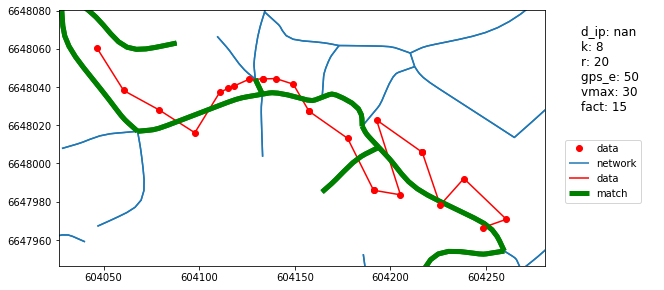

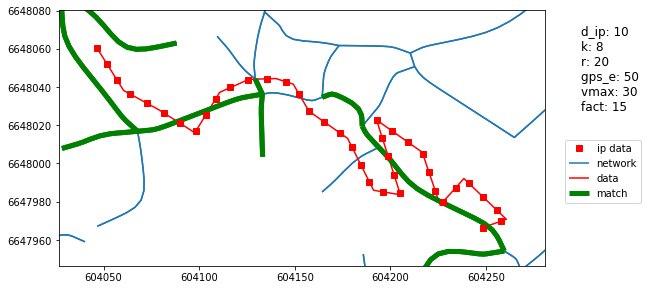

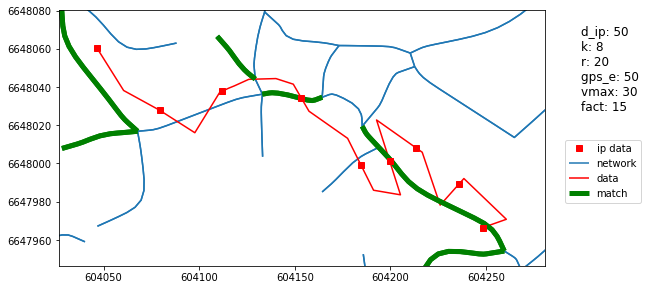

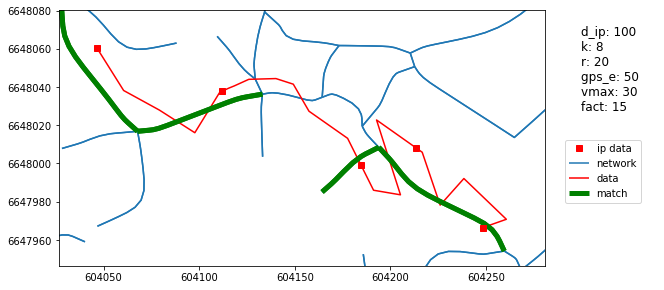

In [39]:
mm = mm_load()
for i in [0, 10, 50, 100]:
    mm = config_match_plot(mm, d=i, radius=radius, factor=factor, with_params=True) 

- Variation of the interpolation distance leads to missing links in the resulting track - __why?__
- All matches include reverse movements.
- The original data is matched best, but with reverse movements. 

## radius

In [40]:
d=0
k = 8
# radius=20
gps_e = 50
vmax = 30
factor=15

Vary the radius distance:

Loaded network: 210 nodes, 458 edges


/home/christianweber/programs/anaconda3/envs/py3fmm/lib/python3.8/site-packages/geopandas/plotting.py:529: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


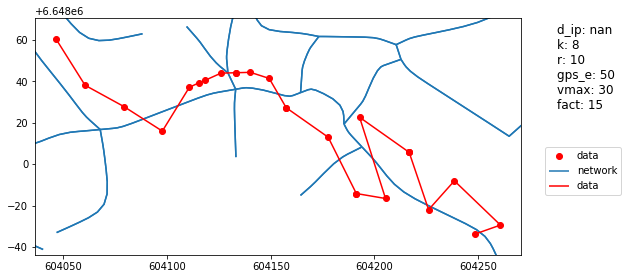

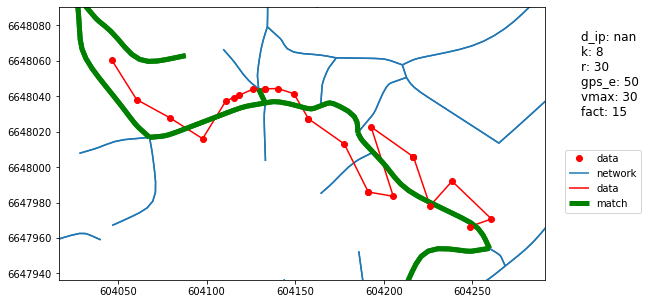

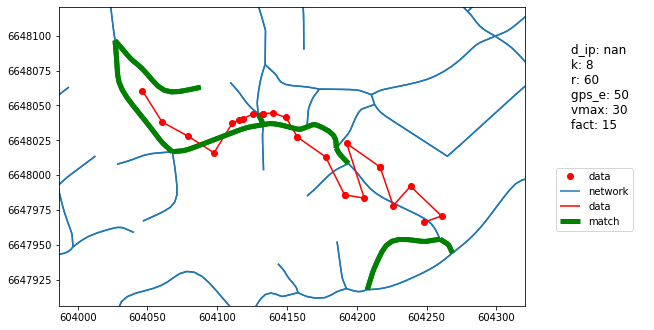

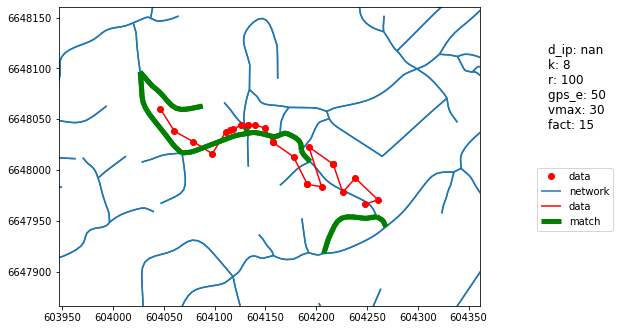

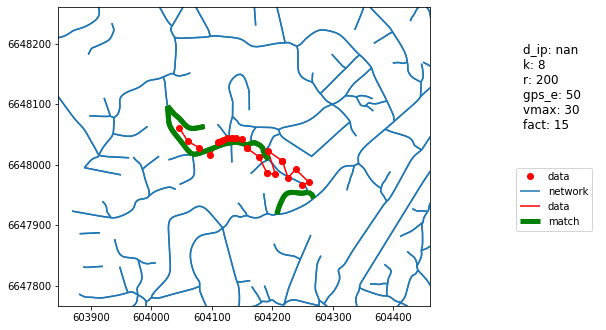

In [41]:
mm = mm_load()
for i in [10, 30, 60, 100, 200]:
    mm = config_match_plot(mm, d=d, radius=i, factor=factor, with_params=True) 

- If the radius is too small, no match is found (r=10)
- A radius of 30 matches these data well, but creates one reverse movement (r=30)
- All larger radii result in missing links - __why?__ (r>30)

## gps error

In [42]:
d=0
k = 8
radius=20
# gps_e = 50
vmax = 30
factor=15

Vary the interpolation distance:

Loaded network: 210 nodes, 458 edges


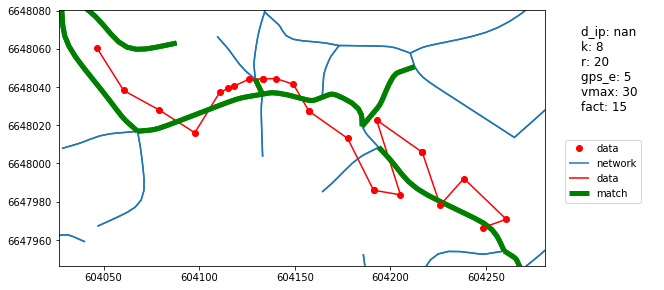

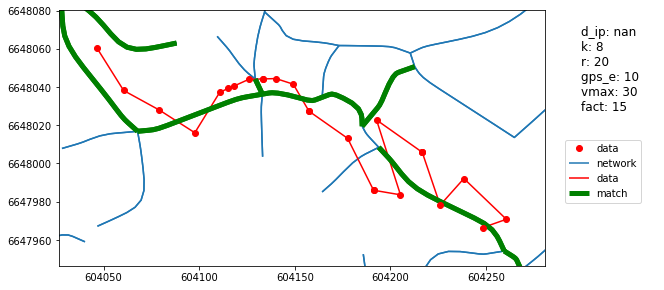

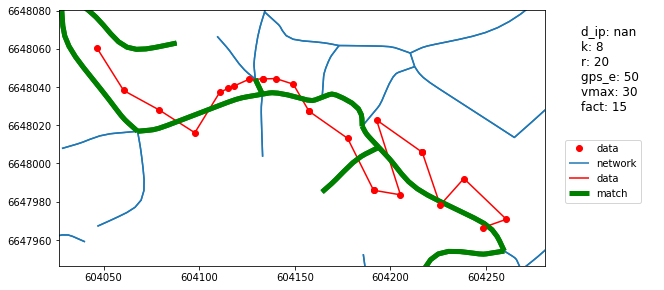

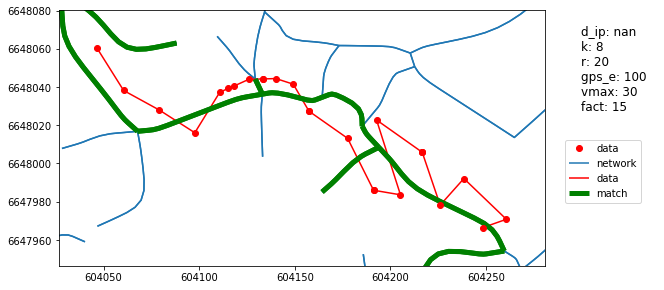

In [43]:
mm = mm_load()
for i in [5, 10, 50, 100]:
    mm = config_match_plot(mm, d=d, radius=radius, gps_error=i, with_params=True) 

- missing links for small gps errors (gps_e < 50)
- reverse movements in all cases

## factor

In [44]:
d=0
k = 8
radius=20
gps_e = 50
vmax = 30
# factor=15

Vary the factor:

Loaded network: 210 nodes, 458 edges


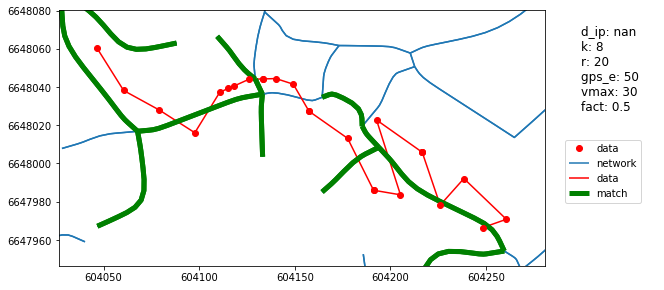

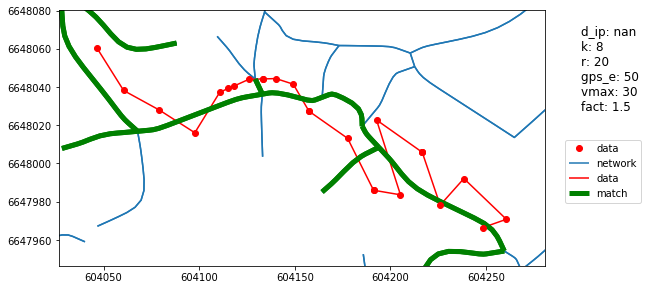

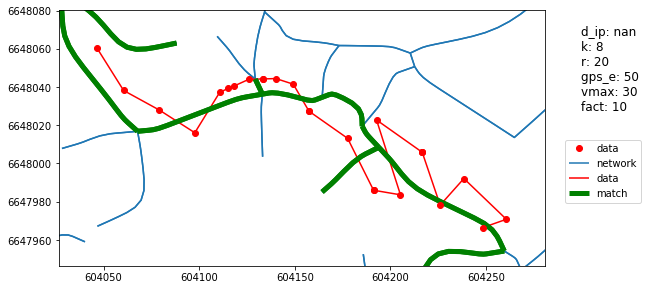

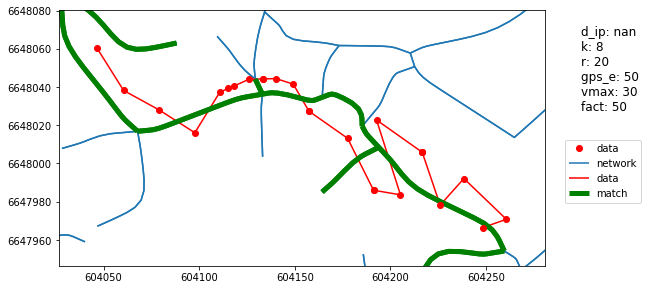

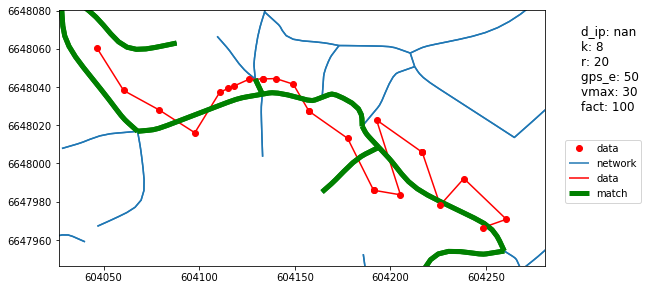

In [45]:
mm = mm_load()
for i in [0.5, 1.5, 10, 50, 100]:
    mm = config_match_plot(mm, d=d, radius=radius, factor=i, with_params=True) 

- The factor seems to have little influence in this example. All factors f > 0.5 result in connected matches
- reverse movement in all cases

## k

In [46]:
d=0
# k = 8
radius=20
gps_e = 50
vmax = 30
factor=15

Vary the number of candidates:

Loaded network: 210 nodes, 458 edges


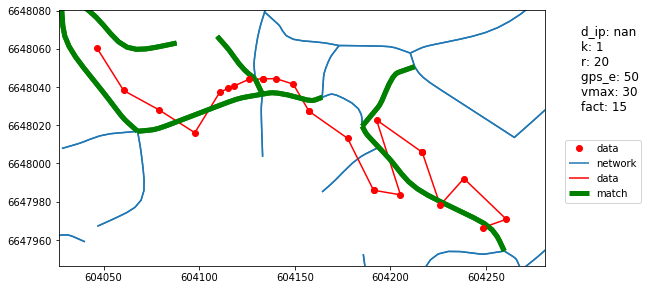

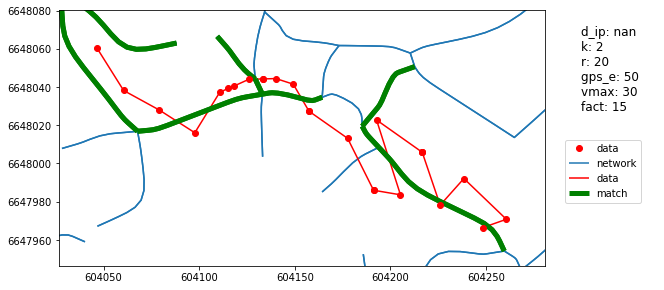

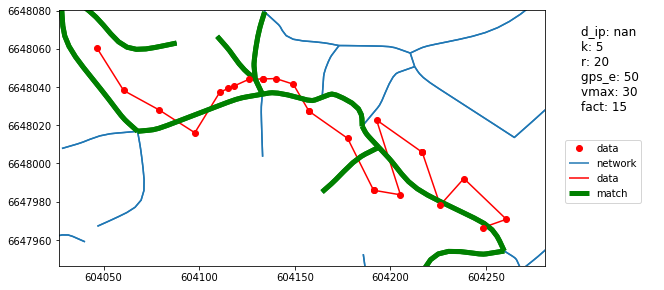

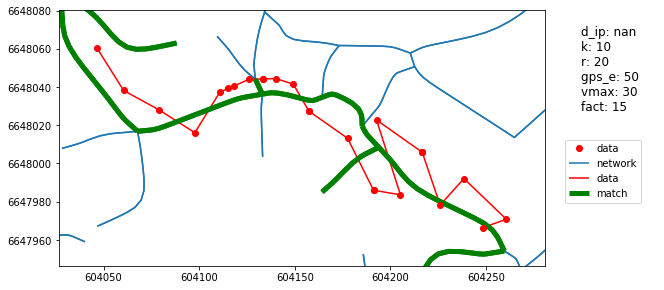

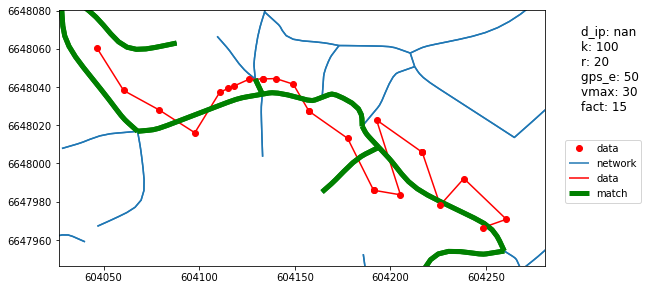

In [47]:
mm = mm_load()
for i in [1, 2, 5, 10, 100]:
    mm = config_match_plot(mm, k=i, d=d, radius=radius, factor=factor, with_params=True) 

- k <= 2 results in non-connected match
- k >= 5: connected matches with reverse movement
- k = 5 leads to the most links with reverse movement. 

# Questions

- What is the best way to tune the parameters? 
- Maybe build a minimizer around them? Some kind of gradient search?
- How can the reverse movements be avoided? 
- Is there any paper available for the STMATCH algorithm? 
- In the FMM-paper, a penalty is mentioned for avoiding reverse movement. Is this still implemented? 
- Will FMM with a precalculated UBODT file give better results? 